In [1]:
from bit_config import *
from utils import *
import torch
from torchsummary import summary
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

model = resmlp_24(pretrained=True)
qmodel = q_resmlp24(model, full_precision_flag=True)

mdict = model.state_dict()
qmdict = qmodel.state_dict()

In [3]:
def get_linear_layers(model):
    linear_layers = []
    for name, module in model.named_modules():
        if isinstance(module, QuantLinear):
            linear_layers.append(module)
    return linear_layers

get_linear_layers(qmodel.layer0)[0].linear.weight.size()

AttributeError: 'QuantLinear' object has no attribute 'linear'

In [ ]:
def cross_layer_equalization(model):
    conv_layers = get_linear_layers(model)
    '''
    Perform Cross Layer Scaling :
    Iterate modules until scale value is converged up to 1e-8 magnitude
    '''
    S_history = dict()
    eps = 1e-8
    converged = [False] * (len(conv_layers)-1)
    with torch.no_grad(): 
        while not np.all(converged):
            for idx in range(1, len(conv_layers)):

                prev, curr = conv_layers[idx-1].linear, conv_layers[idx].linear
                out_channel_prev, in_channel_curr = prev.weight.size()[0], curr.weight.size()[1]

                '''
                prev : [Out_channel, In_channel, H, W]
                curr : [Out_channel, In_channel, H, W]
                For prev layer, we need to obtain a range of 'output channel'
                For curr layer, we need to obtain a range of 'input channel'
                '''
                range_1 = 2.*torch.abs(prev.weight).max(axis = 1)[0].max(axis = 1)[0].max(axis = 1)[0]
                range_2 = 2.*torch.abs(curr.weight).max(axis = 0)[0].max(axis = -1)[0].max(axis = -1)[0]

                S = torch.sqrt(range_1 * range_2) / range_2

                if idx in S_history:
                    prev_s = S_history[idx]
                    if np.all(np.isclose(S.cpu().numpy(), prev_s.cpu().numpy(), atol = eps)):
                        converged[idx-1] = True
                        continue
                    else:
                        converged[idx-1] = False
                s_dim = S.size()[0]
                prev.weight.data.div_(S.view(s_dim, 1, 1, 1))
                prev.bias.data.div_(S)
                prev.gamma.data.div_(S)
                prev.beta.data.div_(S)
                # Generic Conv layer
                if in_channel_curr == out_channel_prev: 
                    curr.weight.data.mul_( S.view(1, s_dim, 1, 1) )
                else:
                    # Depthwise Convolution
                    curr.weight.data.mul_( S.view(s_dim, 1, 1, 1) )
                S_history[idx] = S
    return conv_layers

In [ ]:
plt.rcParams["figure.figsize"] = [20, 5]

plt.rcParams["figure.autolayout"] = True

layer_name = 'layer0.gamma_2.weight'
print("(min, max):  ", (qmdict[layer_name].min(), qmdict[layer_name].max()))
print("(std, mean): ", torch.std_mean(qmdict[layer_name], unbiased=False))
ax = sns.heatmap(qmdict[layer_name])
ax.plot()


In [ ]:
layer_name = 'layer1.gamma_1.weight'
print("(min, max):  ", (qmdict[layer_name].min(), qmdict[layer_name].max()))
print("(std, mean): ", torch.std_mean(qmdict[layer_name], unbiased=False))
ax = sns.heatmap(qmdict[layer_name])
ax.plot()


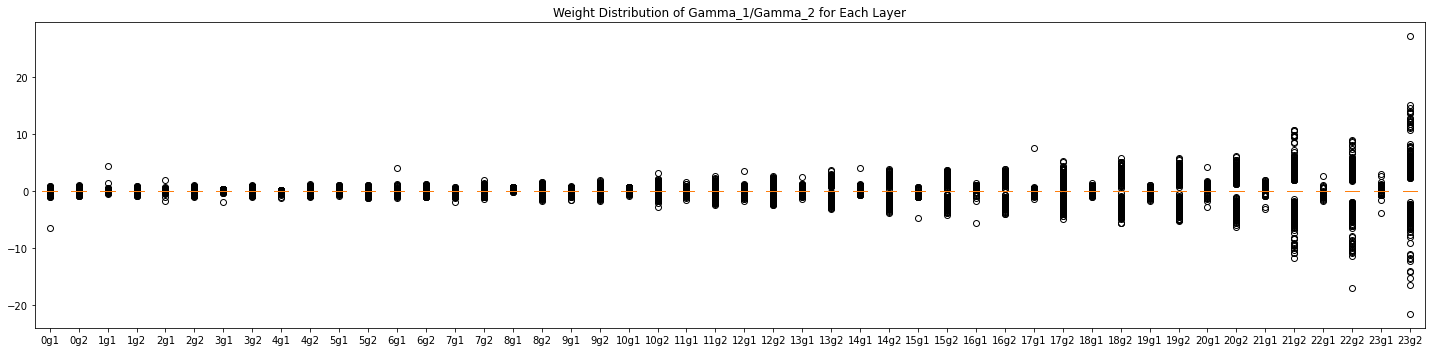

In [21]:
plt.title('Weight Distribution of Gamma_1/Gamma_2 for Each Layer')
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["figure.autolayout"] = True

data = []
labels = []
for i in range(0, 24):
  layer1_name = f'layer{i}.gamma_1.weight'
  data1 = qmdict[layer1_name].detach().numpy().flatten()

  layer2_name = f'layer{i}.gamma_2.weight'
  data2 = qmdict[layer2_name].detach().numpy().flatten()

  # data = np.concatenate([[data1], [data2]], axis=0)
  data.append(data1)
  data.append(data2)
  labels.append(f'{i}g1')
  labels.append(f'{i}g2')
  
# Creating plot
bp = plt.boxplot(data, labels=labels)
plt.show()

In [6]:
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_resolution = 224  

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(train_resolution),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

# simulate input
x = np.array(np.rint(np.random.rand(500, 375, 3) * 255), dtype=np.uint8)
x = transform(x).unsqueeze(0)
# cuda0 = torch.device('cuda:0')
# x = x.to(cuda0)

In [7]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output[0].detach()
    return hook

getattr(qmodel, 'quant_patch').norm.register_forward_hook(get_activation('in'))
for i in range(0, 24):
  layer_name = f'layer{i}'
  layer1_name = f'{i}g1'
  layer2_name = f'{i}g2'
  getattr(qmodel, layer_name).gamma_1.register_forward_hook(get_activation(layer1_name))
  getattr(qmodel, layer_name).gamma_2.register_forward_hook(get_activation(layer2_name))

output = qmodel(x)

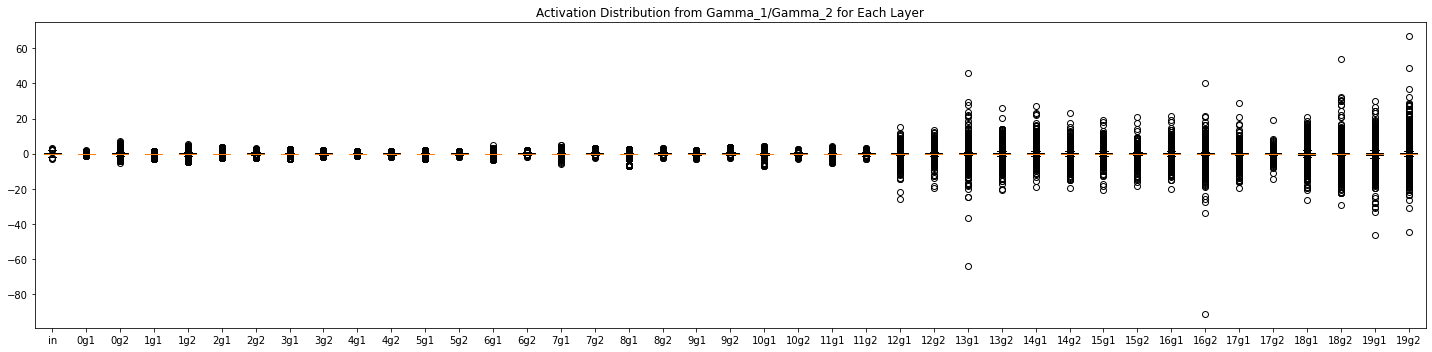

In [16]:
plt.title('Activation Distribution from Gamma_1/Gamma_2 for Each Layer')
plt.rcParams["figure.figsize"] = [20, 5]
# plt.rcParams["figure.figsize"] = [5, 5]

plt.rcParams["figure.autolayout"] = True

data = []
labels = []

from_layers=0
to_layers=20
for name in list(activations)[from_layers*2 : to_layers*2+1]:
  labels.append(name)
  # print(activations[name].shape)
  data.append(activations[name][0].flatten())
  
# Creating plot
bp = plt.boxplot(data, labels=labels)
plt.show()

In [2]:
for a in qmodel.named_modules():
  print(a)

('', Q_ResMLP24(
  (quant_input): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
  (quant_patch): Q_PatchEmbed(
    (proj): (QuantConv2d(
      (conv): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    ) weight_bit=4, bias_bit=32, full_precision_flag=True, quant_mode=symmetric)
    (quant_act_int32): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
    (norm): Identity()
  )
  (layer0): Q_Layer(
    (quant_act): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
    (norm1): (QuantLinear() weight_bit=4, bias_bit=32, full_precision_flag=True, quantize_fn=symmetric)
    (quant_act1): QuantAct(activation_bit=4, full_precision_flag=True, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
    (attn): (QuantLinear() weight_bit=4, bias_bit=32, full_precision_flag=True, quantize_fn=symmetric)
    (quant_act2): QuantAct(